## Imports

In [3]:
pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [1]:
import os
import re
import spacy
import numpy as np
import pandas as pd
import gensim.downloader
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from gensim import corpora, models
from gensim.models import KeyedVectors, LdaModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

## Data loading

In [3]:
filename = "boardgames.csv"
df = pd.read_csv(filename, sep=";")
df.head()

,id,name,description,year,rating,complexity
0,1,Die Macher,Die Macher is a game about seven sequential po...,1986,7.58934,4.3081
1,2,Dragonmaster,Dragonmaster is a trick-taking card game based...,1981,6.65971,1.9643
2,3,Samurai,Samurai is set in medieval Japan. Players comp...,1998,7.47612,2.4423
3,4,Tal der Könige,When you see the triangular box and the luxuri...,1992,6.61540,2.6875
4,5,Acquire,"In Acquire, each player strategically invests ...",1964,7.35072,2.4923


## Task 1: Text Preprocessing and vectorization

### Text Preprocessing

In [4]:
# Load English spaCy model
nlp = spacy.load("en_core_web_sm")

# We implement data cleaning using spaCy
def clean_text(text):
    if pd.isna(text):
        return ""

    # Lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)

    # Remove special characters and numbers
    text = re.sub(r"[^a-z\s]", " ", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Apply spaCy NLP processing
    doc = nlp(text)

    # Remove stopwords, lemmatize words, and exclude punctuations
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

    return " ".join(tokens)

In [5]:
# Apply the cleaning function to all descriptions
df["clean_description"] = df["description"].apply(clean_text)

In [6]:
# Example: original and cleaned text for first entry
print("Original:\n", df["description"][0])
print("Cleaned:\n", df["clean_description"][0])

Original:
 Die Macher is a game about seven sequential political races in different regions of Germany. Players are in charge of national political parties, and must manage limited resources to help their party to victory. The winning party will have the most victory points after all the regional elections. There are four different ways of scoring victory points. First, each regional election can supply one to eighty victory points, depending on the size of the region and how well your party does in it. Second, if a party wins a regional election and has some media influence in the region, then the party will receive some media-control victory points. Third, each party has a national party membership which will grow as the game progresses and this will supply a fair number of victory points. Lastly, parties score some victory points if their party platform matches the national opinions at the end of the game.&#10;&#10;The 1986 edition featured four parties from the old West Germany and

#### Save clean dataset (if desired)

In [7]:
df.to_csv("boardgames_clean.csv", index=False, encoding="utf-8", sep=";")

### Vectorization

#### BoW and TF-IDF

In [8]:
# For this task, we will mainly be working with the column "clean_description".
# We will tokenize this part fist
tokenized_descr = [clean_description.split() for clean_description in df["clean_description"]]

In [9]:
# Then we will create a dictionary and obtain both the BoW corpus and the TF-IDF corpus
# BoW corpus
dictionary = corpora.Dictionary(tokenized_descr)
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_descr]

# TF-IDF corpus
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

Now we would like to obtain some insights from our data using the TF-IDF corpus. However, we cannot use it as it is. `tfidf_corpus`is a sparse corpus matrix, not a dense numpy matrix.

Gensim is optimized for streaming large corpora and if we wanted to do some visualizations, we would need to convert it to dense form.

In [10]:
num_docs = len(tfidf_corpus)
num_terms = len(dictionary)

# Create empty matrix
X_tfidf_gensim = np.zeros((num_docs, num_terms))

# Fill it with TF-IDF scores
for doc_idx, doc in enumerate(tfidf_corpus):
    for term_id, tfidf_score in doc:
        X_tfidf_gensim[doc_idx, term_id] = tfidf_score

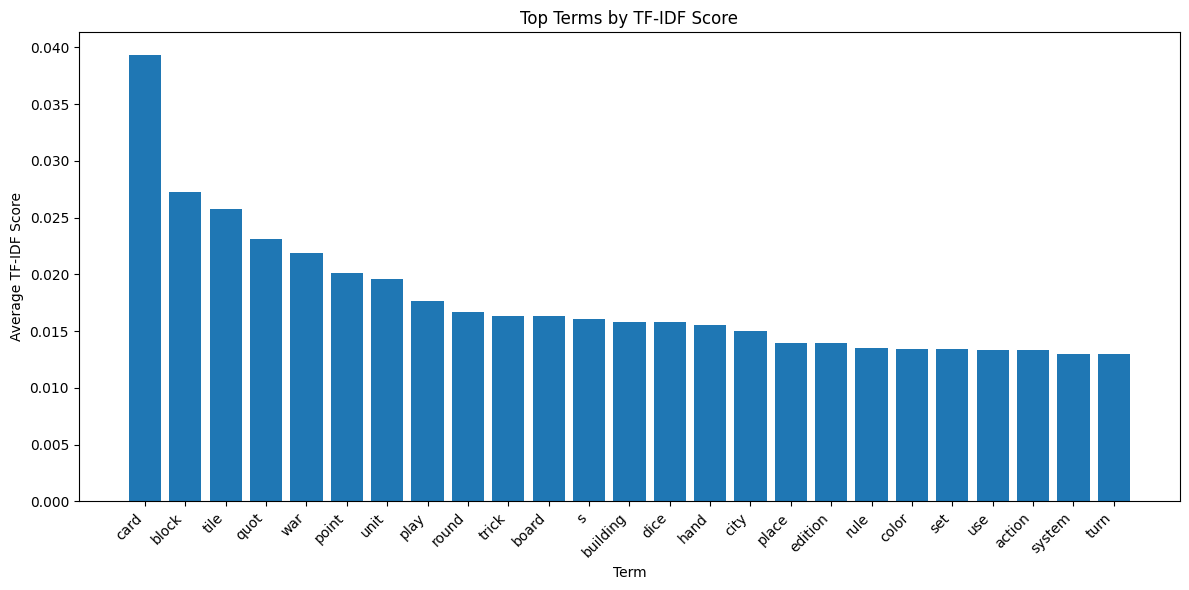

In [11]:
# Compute average TF-IDF per term
avg_tfidf_scores = X_tfidf_gensim.mean(axis=0)

# Top-N terms
top_n = 25
top_term_indices = avg_tfidf_scores.argsort()[::-1][:top_n]

# Get corresponding terms
terms = [dictionary[i] for i in top_term_indices]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(top_n), avg_tfidf_scores[top_term_indices], tick_label=terms)
plt.xlabel('Term')
plt.ylabel('Average TF-IDF Score')
plt.title('Top Terms by TF-IDF Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

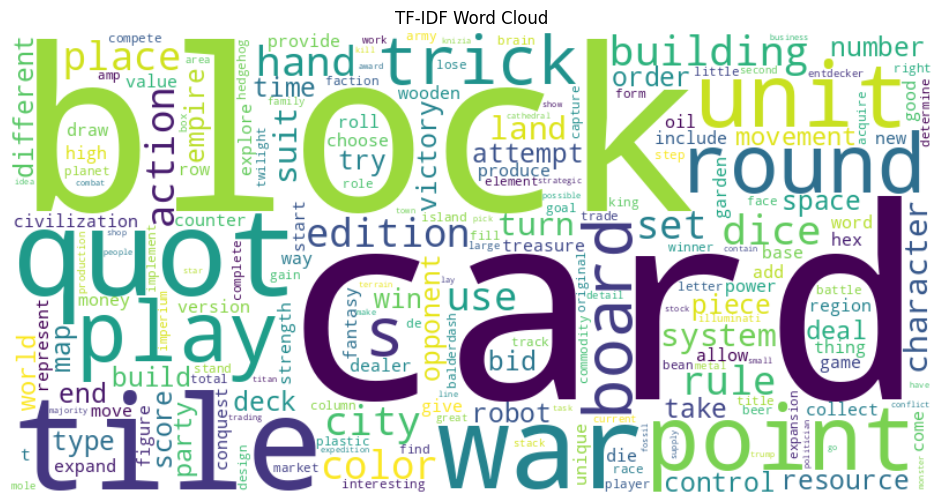

In [12]:
# Total TF-IDF score per term across all documents
tfidf_term_scores = X_tfidf_gensim.sum(axis=0)

# Map term to score
word_freq = {dictionary[i]: tfidf_term_scores[i] for i in range(num_terms)}

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate_from_frequencies(word_freq)

# Display
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('TF-IDF Word Cloud')
plt.show()

#### GloVe and Doc2Vec

In [13]:
# Load pretrained GloVe
w2v_model = gensim.downloader.load("glove-wiki-gigaword-100")

def get_avg_vector(doc):
    words = doc.split()
    vectors = [w2v_model[word] for word in words if word in w2v_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

# Create document embeddings
X_w2v = np.vstack(df["clean_description"].apply(get_avg_vector))

[==================================================] 100.0% 128.1/128.1MB downloaded


In [14]:
# Prepare data
documents = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(df["clean_description"])]

# Train
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=2, workers=4, epochs=40)

# Vectorize
X_doc2vec = np.array([doc2vec_model.dv[str(i)] for i in range(len(documents))])

#### LDA

In [15]:
corpus = df['clean_description'].tolist()

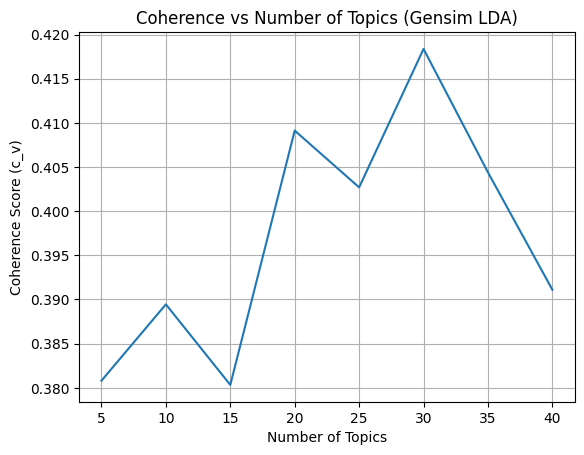

In [16]:
# Try different numbers of topics
coherence_scores = []
models = []
for k in range(5, 41, 5):
    model = LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=k, passes=15, random_state=42)
    coherence = CoherenceModel(model=model, texts=tokenized_descr, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_scores.append(coherence)
    models.append(model)

# Plot coherence vs. topic count
import matplotlib.pyplot as plt
plt.plot(range(5, 41, 5), coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence vs Number of Topics (Gensim LDA)")
plt.grid(True)
plt.show()

# Select best model
best_k = range(5, 41, 5)[np.argmax(coherence_scores)]
best_model = models[np.argmax(coherence_scores)]

In [17]:
for topic_id, words in best_model.show_topics(num_topics=best_k, num_words=10, formatted=False):
    print(f"Topic {topic_id}: {[word for word, prob in words]}")


Topic 0: ['card', 'player', 'game', 'quot', 'order', 'robot', 's', 'hand', 'trick', 'resource']
Topic 1: ['temple', 'treasure', 'tikal', 'player', 'game', 'jungle', 'lose', 'score', 'attempt', 'point']
Topic 2: ['player', 'game', 'card', 'edition', 'twilight', 'tile', 'imperium', 'round', 'building', 'rule']
Topic 3: ['player', 'game', 'tower', 'fossil', 'pick', 'reward', 'computer', 'chocolate', 'take', 'win']
Topic 4: ['entdecker', 'player', 'island', 'land', 'game', 'new', 's', 'explore', 'board', 'place']
Topic 5: ['card', 'player', 'play', 'game', 'point', 'expedition', 'oil', 'color', 'total', 'trick']
Topic 6: ['game', 'empire', 'player', 'federation', 'operation', 'expansion', 'quot', 'rule', 'version', 'battle']
Topic 7: ['game', 'party', 'player', 'victory', 'card', 'point', 'arena', 'creature', 's', 'play']
Topic 8: ['game', 'block', 'war', 'unit', 'provide', 'use', 'system', 'strength', 'allow', 'quot']
Topic 9: ['card', 'player', 'bid', 'game', 'deck', 'hand', 'illuminati'

In [18]:
beta_matrix = np.array(best_model.get_topics())
print("Beta shape:", beta_matrix.shape)

Beta shape: (30, 2608)


In [19]:
words = [dictionary[i] for i in range(len(dictionary))]

# We create a dataframe to read the results better
beta_df = pd.DataFrame(beta_matrix, columns=words, index=[f"Topic {i}" for i in range(best_k)])

# Here we display the top words per topic (beta vectors), with the probabilities.
for topic_id in range(best_k):
    print(f"\nTopic {topic_id}:")
    print(beta_df.iloc[topic_id].sort_values(ascending=False).head(10))



Topic 0:
card        0.044942
player      0.041389
game        0.017614
quot        0.016487
order       0.016341
robot       0.015461
s           0.015094
hand        0.014543
trick       0.010133
resource    0.010021
Name: Topic 0, dtype: float32

Topic 1:
temple      0.031727
treasure    0.023865
tikal       0.023865
player      0.016012
game        0.016006
jungle      0.015997
lose        0.015996
score       0.008135
attempt     0.008133
point       0.008133
Name: Topic 1, dtype: float32

Topic 2:
player      0.042692
game        0.036076
card        0.017859
edition     0.016632
twilight    0.012805
tile        0.012791
imperium    0.011528
round       0.010258
building    0.010249
rule        0.009015
Name: Topic 2, dtype: float32

Topic 3:
player       0.027646
game         0.018812
tower        0.016831
fossil       0.013494
pick         0.010148
reward       0.010147
computer     0.010141
chocolate    0.010123
take         0.008660
win          0.008406
Name: Topic 3, dtype

In [20]:
best_model.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

# igual usar esto que es más compacto


[(0,
  '0.045*"card" + 0.041*"player" + 0.018*"game" + 0.016*"quot" + 0.016*"order" + 0.015*"robot" + 0.015*"s" + 0.015*"hand" + 0.010*"trick" + 0.010*"resource"'),
 (1,
  '0.032*"temple" + 0.024*"treasure" + 0.024*"tikal" + 0.016*"player" + 0.016*"game" + 0.016*"jungle" + 0.016*"lose" + 0.008*"score" + 0.008*"attempt" + 0.008*"point"'),
 (2,
  '0.043*"player" + 0.036*"game" + 0.018*"card" + 0.017*"edition" + 0.013*"twilight" + 0.013*"tile" + 0.012*"imperium" + 0.010*"round" + 0.010*"building" + 0.009*"rule"'),
 (3,
  '0.028*"player" + 0.019*"game" + 0.017*"tower" + 0.013*"fossil" + 0.010*"pick" + 0.010*"reward" + 0.010*"computer" + 0.010*"chocolate" + 0.009*"take" + 0.008*"win"'),
 (4,
  '0.028*"entdecker" + 0.022*"player" + 0.020*"island" + 0.019*"land" + 0.018*"game" + 0.016*"new" + 0.013*"s" + 0.013*"explore" + 0.012*"board" + 0.010*"place"'),
 (5,
  '0.082*"card" + 0.039*"player" + 0.036*"play" + 0.029*"game" + 0.025*"point" + 0.024*"expedition" + 0.020*"oil" + 0.020*"color" + 0.0

In [21]:
theta_matrix = []
for doc in bow_corpus:
    doc_topics = best_model.get_document_topics(doc, minimum_probability=0)
    theta_matrix.append([prob for _, prob in doc_topics])

theta_matrix = np.array(theta_matrix)
print("Theta shape:", theta_matrix.shape)


Theta shape: (122, 30)


In [22]:
# Dataframe for the thetas
theta_df = pd.DataFrame(theta_matrix, columns=[f"Topic {i}" for i in range(best_k)])

# We just display the most relevant topic (the one with the highest probability)
theta_df["Dominant Topic"] = theta_df.idxmax(axis=1)

print(theta_df[["Dominant Topic"]])


    Dominant Topic
0          Topic 7
1          Topic 0
2         Topic 11
3         Topic 11
4         Topic 17
..             ...
117       Topic 18
118        Topic 9
119       Topic 22
120        Topic 9
121        Topic 4

[122 rows x 1 columns]


In [23]:
#pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, bow_corpus, dictionary)
vis


In [24]:
from transformers import pipeline
import pandas as pd
from tqdm import tqdm



# Define candidate tone labels
labels = [
    "funny", "dark", "serious", "scary", "happy",
    "strategic", "family-friendly", "intense", "historical", "light-hearted"
]

# Load the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Apply classification to each description
def classify_tone(description):
    result = classifier(description, labels)
    # Return the top label
    return result['labels'][0]

# Apply to all rows with progress bar
tqdm.pandas()
df["predicted_tone"] = df["clean_description"].progress_apply(classify_tone)

# Save or inspect
df.to_csv("bgg_with_tones.csv", index=False)
print(df[["name", "predicted_tone"]].head())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0
100%|██████████| 122/122 [00:44<00:00,  2.71it/s]

             name predicted_tone
0      Die Macher      strategic
1    Dragonmaster     historical
2         Samurai     historical
3  Tal der Könige          happy
4         Acquire      strategic


In [28]:
# Show a few examples of descriptions with their predicted tone
num_examples = 100 # You can change this number
for i in range(num_examples):
    print(f"\n Game: {df.iloc[i]['name']}")
    print(f" Description:\n{df.iloc[i]['clean_description'][:500]}...")  # Show first 500 chars
    print(f" Predicted Tone: {df.iloc[i]['predicted_tone']}")



 Game: Die Macher
 Description:
die macher game seven sequential political race different region germany player charge national political party manage limited resource help party victory win party victory point regional election different way scoring victory point regional election supply eighty victory point depend size region party second party win regional election medium influence region party receive medium control victory point party national party membership grow game progress supply fair number victory point lastly par...
 Predicted Tone: strategic

 Game: Dragonmaster
 Description:
dragonmaster trick taking card game base old game call coup d tat player give supply plastic gem represent point player dealer different hand slightly different goal hand card deal dealer decide hand good suit current card player penalize point form crystal take certain trick card instance quot quot quot quot call player penalize take trick player chance dealer hand player steal opportunity take tr